In [60]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [61]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Interpolations

In [62]:
using Revise
using Will

In [74]:
function plot_pmd(w, i, ell_list="ell_vector.npy")
    ell_vector = npzread("ell_vector.npy")
    ℓ = round(ell_vector[i], digits=1)
    p = heatmap(log10.(abs.(w[i,:,:]./maximum(w[i,:,:]))), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Projected Matter density, ℓ=$(ℓ)")
    return plot(p, layout=(1,1))
end;

# Adapting N5K stuff to my grid until I'm able to install pyccl :'(

In [63]:
#Import window functions
W = npzread("../N5K/input/kernels_fullwidth.npz")
WA = W["kernels_sh"]
WB = W["kernels_cl"]

nχ = 100
χ = LinRange(13, 7000, nχ) 
WA_interp = zeros(5,nχ)
WB_interp = zeros(10,nχ)

for i in 1:5
    interp = BSplineInterpolation(WA[i,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
    WA_interp[i,:] = interp.(χ)
end

for i in 1:10
    interp = BSplineInterpolation(WB[i,:], W["chi_cl"], 3, :ArcLen, :Average, extrapolate=true)
    WB_interp[i,:] = interp.(χ)
end

In [64]:
#import power spectrum
pk_dict = npzread("../N5K/input/pk.npz");

In [66]:
interp = BSplineInterpolation(W["chi_cl"], W["z_cl"], 3, :ArcLen, :Average, extrapolate=true)
my_chi = interp.(pk_dict["z"]);

In [67]:
itp = interpolate((my_chi, log10.(pk_dict["k"])), log10.(pk_dict["pk_lin"]), Gridded(Linear()))
itp_with_extrapolation = extrapolate(itp, Line());

In [68]:
#Define our grid
kmax = 200/13 
kmin = 2.5/7000
k = LinRange(kmin, kmax, 40000)
nχ = 100
χ = LinRange(26, 7000, nχ)

log_pk_interp = [itp_with_extrapolation(i, j) for i in χ, j in log10.(k)];

In [69]:
function power_spectrum(k, χ1, χ2, interpolator)
    P1 = 10 .^interpolator(χ1, k)
    P2 = 10 .^interpolator(χ2, k)
    
    return @. sqrt(P1 * P2)
end

power_spectrum(k, χ1, χ2) = power_spectrum(k, χ1, χ2, itp_with_extrapolation);

# $w_{\ell}$ with k factors in the Chebyshev decomposition
#### Decomposing $f(k)P(k,\chi_1, \chi_2)$ on the Chebyshev polynomials

$$f(k) = \begin{cases}
k^2 \text{   CC} \\
\frac{1}{k^2} \text{   LL} \\
1 \text{   CL}
\end{cases}$$

In [10]:
n_cheb = 128
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));

In [11]:
coeff_CC = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp( ((10 .^k_cheb) .^2) .* power_spectrum(k_cheb,χ[i],χ[j]), log10(kmin), log10(kmax));
        coeff_CC[i,j,:] = c.coefs
        coeff_CC[j,i,:] = coeff_CC[i,j,:]
    end
end

In [12]:
coeff_LL = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum(k_cheb,χ[i],χ[j]) ./ ((10 .^k_cheb) .^2), log10(kmin), log10(kmax));
        coeff_LL[i,j,:] = c.coefs
        coeff_LL[j,i,:] = coeff_LL[i,j,:]
    end
end
i = 50
c = chebinterp(power_spectrum(k_cheb,χ[i],χ[i]) ./ ((10 .^k_cheb) .^2), log10(kmin), log10(kmax));

In [13]:
coeff_CL = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum(k_cheb,χ[i],χ[j]), log10(kmin), log10(kmax));
        coeff_CL[i,j,:] = c.coefs
        coeff_CL[j,i,:] = coeff_CL[i,j,:]
    end
end

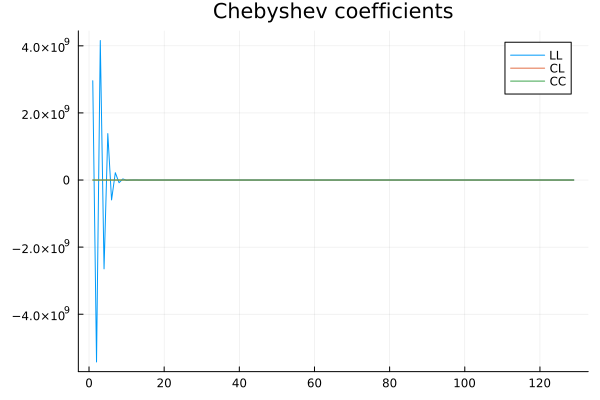

In [288]:
i=5
j=90
plot([collect(1:129)], coeff_LL[i,j,:], label = "LL", title = "Chebyshev coefficients")
plot!([collect(1:129)], coeff_CL[i,j,:], label = "CL")
plot!([collect(1:129)], coeff_CC[i,j,:], label = "CC")

    If  in the next cell I load T_tilde, those are the first T's evaluated (with the lower precision requirements). All of them are ready now.
    If I load T_tilde_CL, those are the one I've been trying to evaluate with the higher precision requirement. Only 4 of those are ready at the moment.

In [86]:
function load_Ts(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [87]:
T_tot = load_Ts(nχ,n_cheb);

In [88]:
ws_cheb_CC = Will.w_ell_tullio(coeff_CC, T_tot)
ws_cheb_LL = Will.w_ell_tullio(coeff_LL, T_tot)
ws_cheb_CL = Will.w_ell_tullio(coeff_CL, T_tot);

In [89]:
function plot_pmd(w, i, ell_list="ell_vector.npy")
    ell_vector = npzread("ell_vector.npy")
    ℓ = round(ell_vector[i], digits=1)
    p = heatmap(log10.(abs.(w[i,:,:]./maximum(w[i,:,:]))), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Projected Matter density, ℓ=$(ℓ)")
    return plot(p, layout=(1,1))
end;

#### clustering - clustering

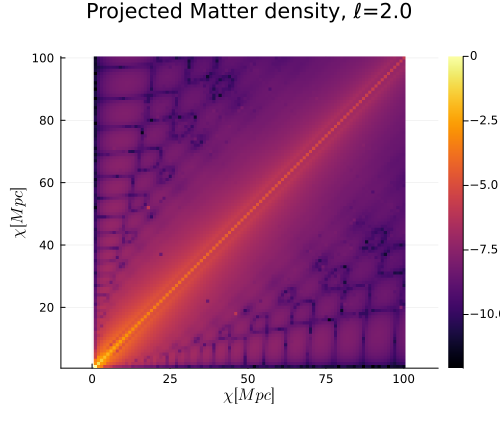

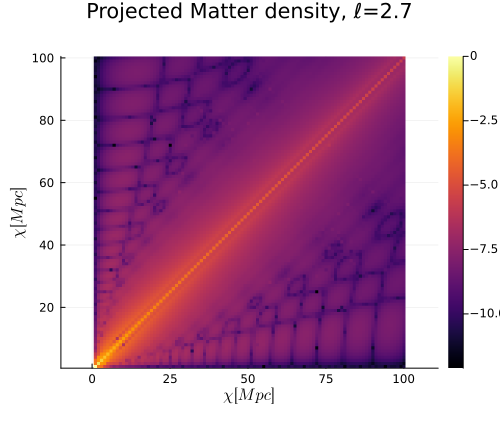

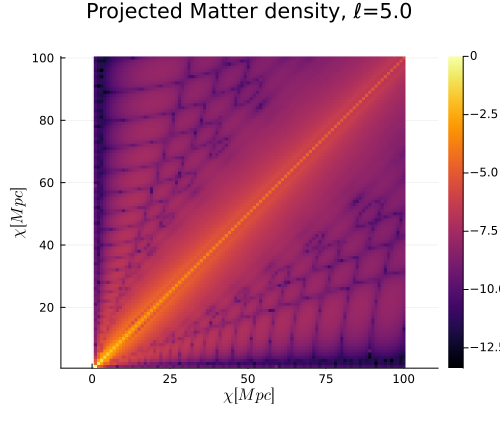

In [90]:
plots = []
for i in 1:3
    push!(plots, plot_pmd(ws_cheb_CC, i))
end

for plot in plots
    display(plot)
end

#### Lensing - lensing

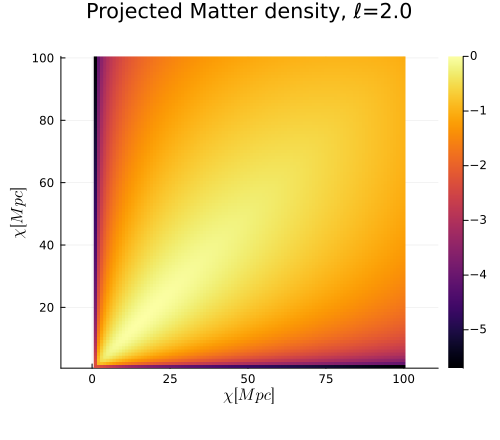

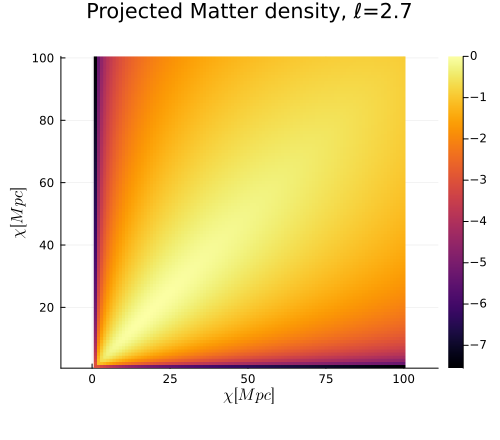

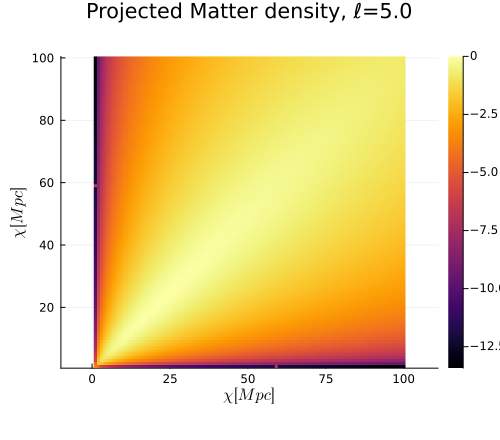

In [91]:
plots = []
for i in 1:3
    push!(plots, plot_pmd(ws_cheb_LL, i))
end

for plot in plots
    display(plot)
end

#### Clustering - lensing

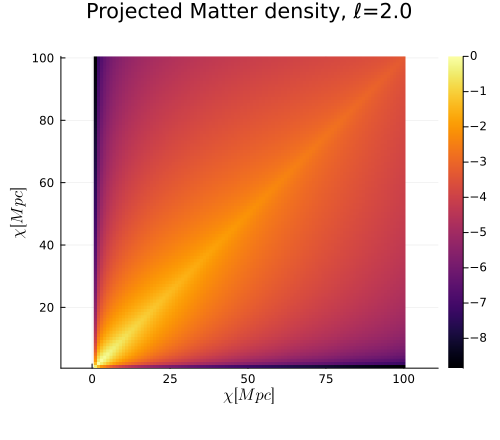

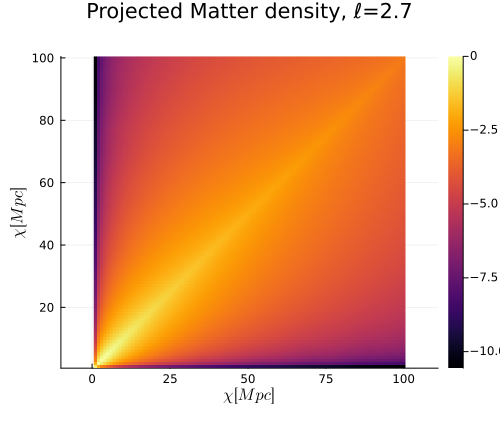

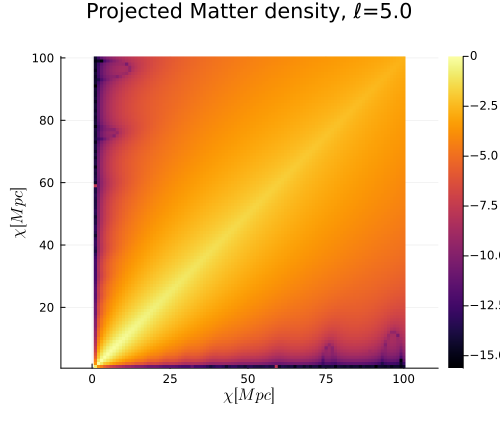

In [92]:
plots = []
for i in 1:3
    push!(plots, plot_pmd(ws_cheb_CL, i))
end

for plot in plots
    display(plot)
end

#### Let's see some diagonals

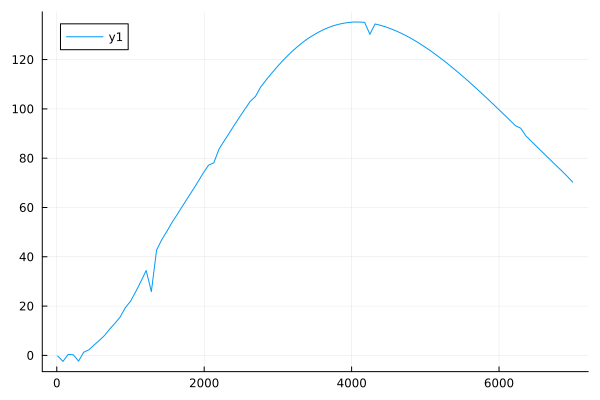

In [182]:
i=10
plot(χ, diag(ws_cheb_LL[i,:,:]))

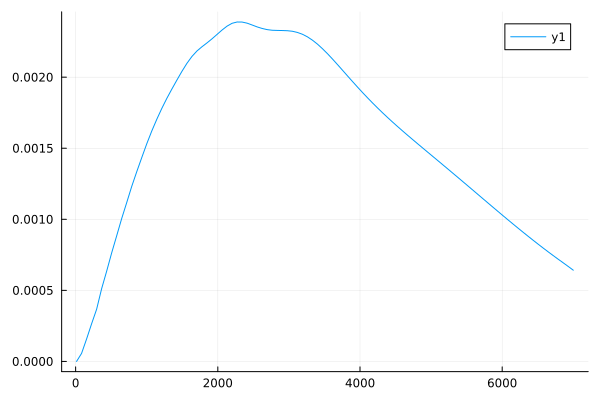

In [95]:
i=21
plot(χ, diag(ws_cheb_CL[i,:,:]))

    Queste CL sono tutte lisce!

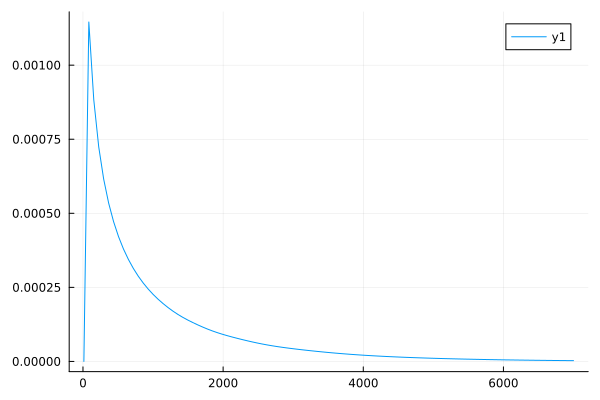

In [96]:
i = 21
plot(χ, diag(ws_cheb_CC[i,:,:]))

    All of those are smooth again! What's up with w_LL?

    Now the plots are fine: that's because I'm using the T with the higher intergration precision. This is also the reason why I'm showing the first two, the rest is still calculating on cluster. Let's also note that the problems before arised at higher $\ells$, so we need to wait more to actually assess the results. The cells below show why it was necessary to increase the precision of the integrals.

### Why the $\tilde T$ need more precision (and probably putting the $k$ factors in the $\tilde T$ is the best choice)
**Do not recompile the following cell block it wouldn't work again!**

In [25]:
ell_vector = npzread("ell_vector.npy") 

function integral!(result, f, kmin, kmax, i, j)
    int, error = hquadrature(f, kmin, kmax; rtol=sqrt(1e-11), atol=0, maxevals=Int(1e7), initdiv=1)
    result[i,j] = int
    result[j,i] = int
    return nothing
end

function brute_w_diagonal!(result, ℓ, χ, kmin, kmax)
    for i in 1:length(χ)
            benchmark_f(x) = Bessels.sphericalbesselj.(ℓ, χ[i] * x) * Bessels.sphericalbesselj.(ℓ, χ[i] * x) * power_spectrum(log10.(x),χ[i],χ[i]) ./ (x .^2)
            integral!(result, benchmark_f, kmin, kmax, i, i)
        end
end

brute_w_diagonal! (generic function with 1 method)

In [26]:
results = zeros(nχ, nχ)
brute_w_diagonal!(results, ell_vector[15], χ, kmin, kmax)

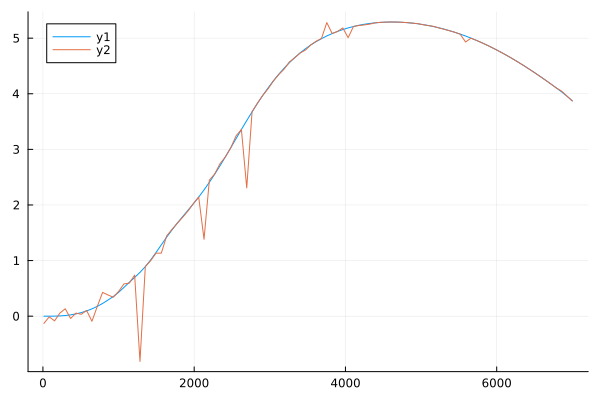

In [27]:
plot(χ, diag(results))
plot!(χ, diag(ws_cheb_LL[15,:,:]))

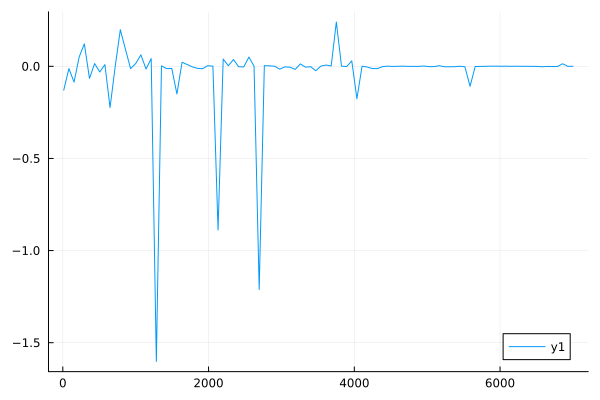

In [28]:
plot(χ, diag(ws_cheb_LL[15,:,:])-diag(results))

In [29]:
diff = abs.(diag(ws_cheb_LL[15,:,:])-diag(results))
indeces = sortperm(diff, rev=true)
diff[indeces][1:15];

In [30]:
#Diciamo che voglio correggere questi primi 15 punti
#gli indici che voglio ricalcolare sono
indeces[1:15];
#in questi indici mi calcolo i T con i fattori k inclusi (ora lo faccio per LL) 
# l'idea è rendere smooth la cosa non smooth che ho :)

#### $w_{\ell}$ with k factor in T

In [21]:
coeff = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum(k_cheb,χ[i],χ[j]), log10(kmin), log10(kmax));
        coeff[i,j,:] = c.coefs
        coeff[j,i,:] = coeff[i,j,:]
    end
end
c = chebinterp(power_spectrum(k_cheb,χ[1],χ[1]), log10(kmin), log10(kmax));

In [32]:
function double_bessel_integral!(result, f, kmin, kmax, i, j, ℓ, χ)
    benchmark_f(x) = Bessels.sphericalbesselj.(ℓ, χ[i] * x) * Bessels.sphericalbesselj.(ℓ, χ[j] * x)*f(log10(x))/x^2
    int, err = HCubature.hquadrature(benchmark_f, kmin, kmax; rtol=sqrt(1e-11), atol=0, maxevals=Int(1e7), initdiv=1)
    #println("Result ", int)
    result[i,j] = int
    result[j,i] = int
    return nothing
end

function cheb_integral(result, n_cheb, i, j, ℓ, χ, kmin, kmax, c)
    w = zeros(n_cheb+1)
    Threads.@threads for myi in 1:n_cheb+1
        copy_c = deepcopy(c) #copio l'interpolante 
        copy_c.coefs .*= 0 #azzero i coeff del polinomio
        copy_c.coefs[myi] = 1. #tranne quello in posizione i (quello che voglio interpolare)
        double_bessel_integral!(result, copy_c, kmin, kmax, i, j, ℓ, χ)  #TODO check log scale, it's very inconsistent!
        w[myi] = result[i,j]
    end
    return w
end

cheb_integral (generic function with 1 method)

In [33]:
result_scatter = zeros(nχ, nχ)
T = zeros(1,nχ,nχ,n_cheb+1)
for i in indeces[1:15]
    T[1, i, i, :] = cheb_integral(result_scatter, n_cheb, i, i, ell_vector[15], χ, kmin, kmax, c)
end

In [34]:
w_fix = Will.w_ell_tullio(coeff, T);

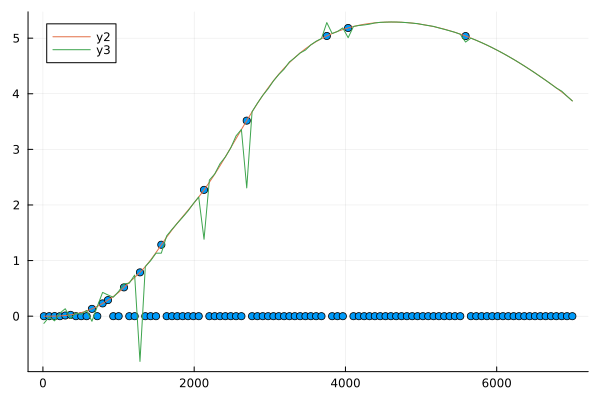

In [35]:
scatter(χ, diag(w_fix[1,:,:]), label=nothing)
plot!(χ, diag(results))
plot!(χ, diag(ws_cheb_LL[15,:,:]))

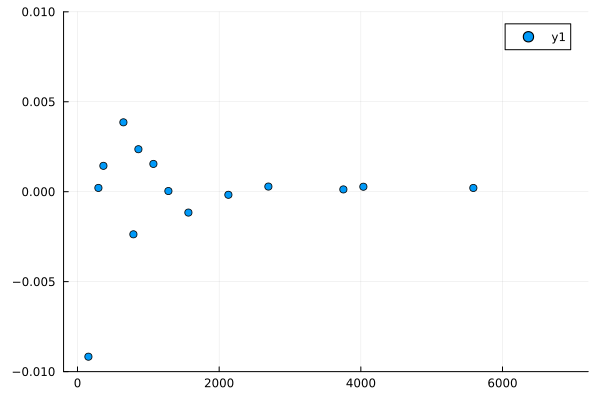

In [36]:
scatter(χ, 1 .-(diag(w_fix[1,:,:]) ./ diag(results)))
ylims!(-0.01, 0.01)

Putting the k factors in T seems to deliver a more numerically stable result. This will be better assesd in the following sections :)

# $w_{\ell}$ with k factors in $\tilde T$

##### CLUSTERING - CLUSTERING

In [70]:
function load_T_CC(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_CC/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [71]:
n_cheb = 128
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum(k_cheb,χ[i],χ[j]), log10(kmin), log10(kmax));
        coeff[i,j,:] = c.coefs
        coeff[j,i,:] = coeff[i,j,:]
    end
end
#c = chebinterp(power_spectrum(k_cheb,χ[1],χ[1]), log10(kmin), log10(kmax));

In [72]:
T_CC = load_T_CC(nχ, n_cheb)
w_CC = Will.w_ell_tullio(coeff, T_CC);

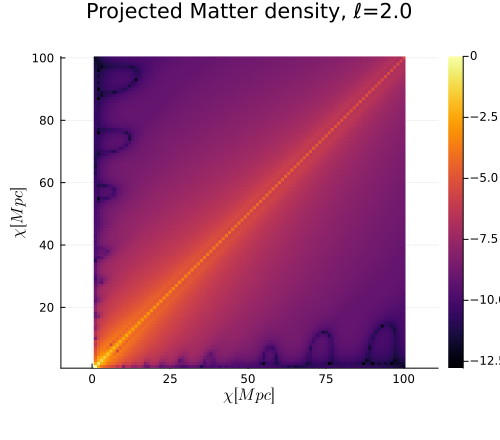

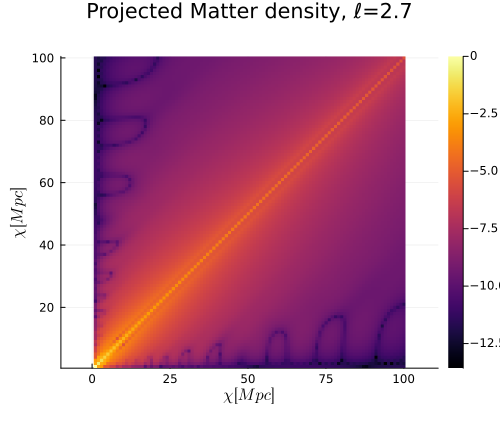

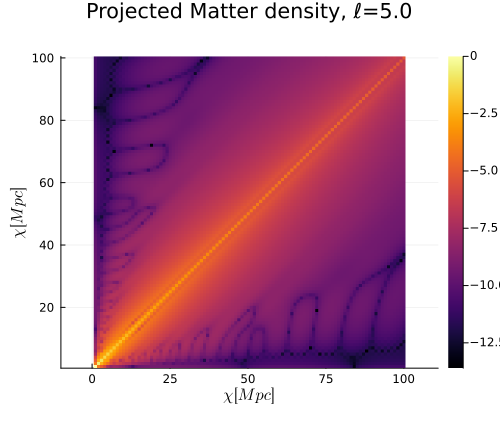

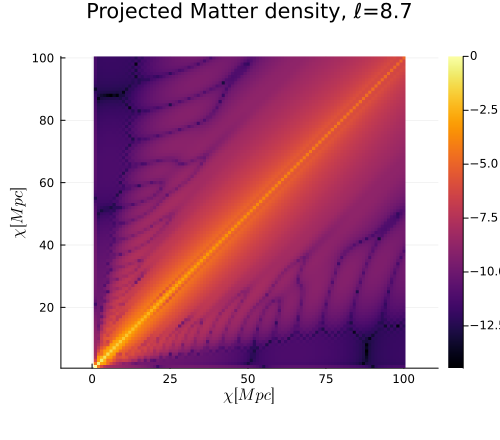

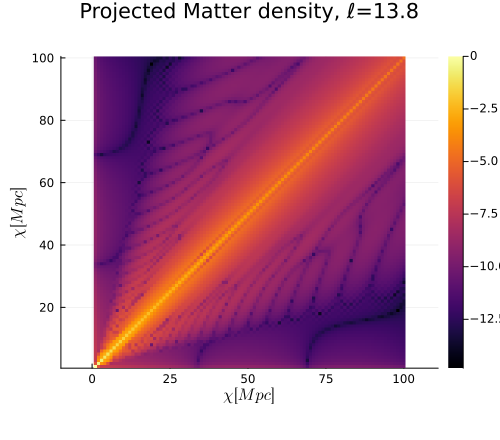

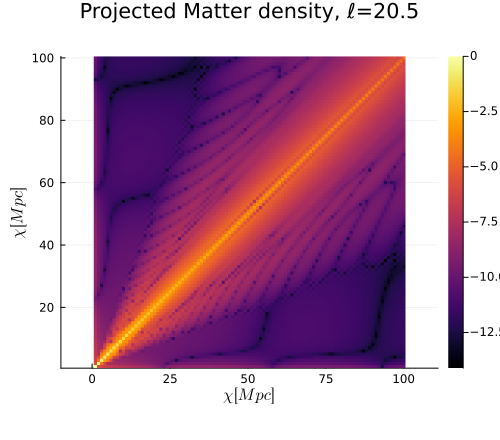

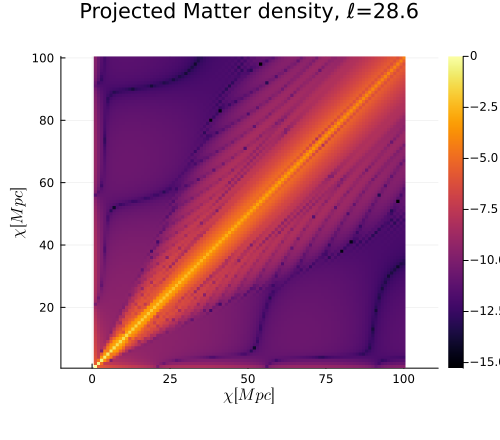

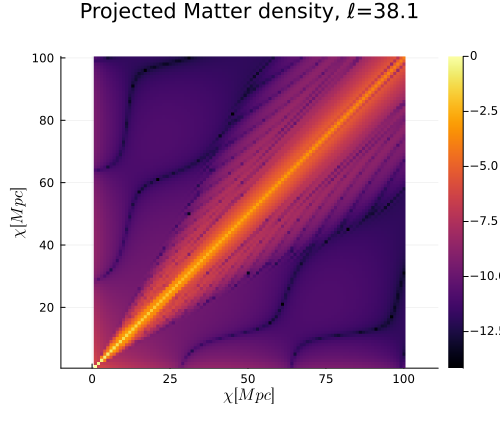

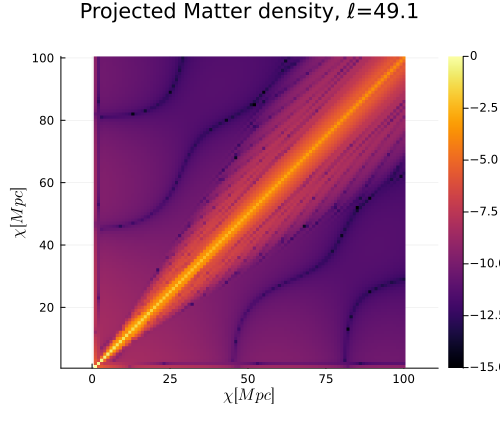

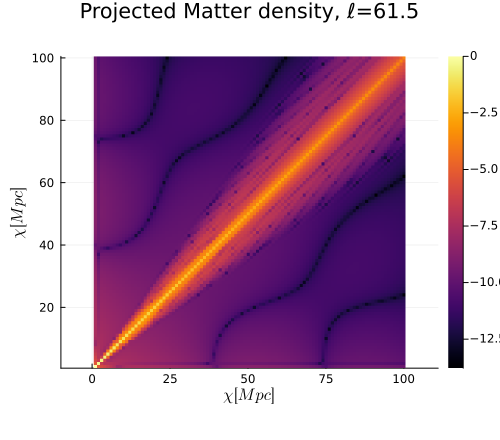

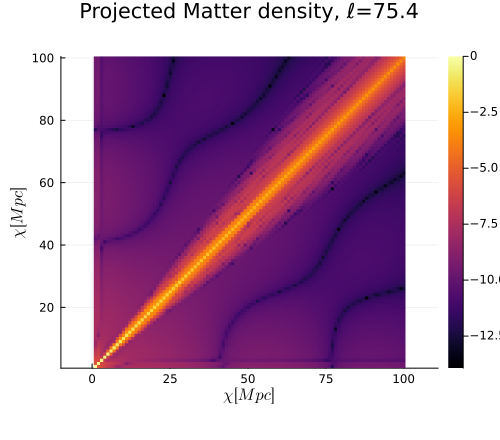

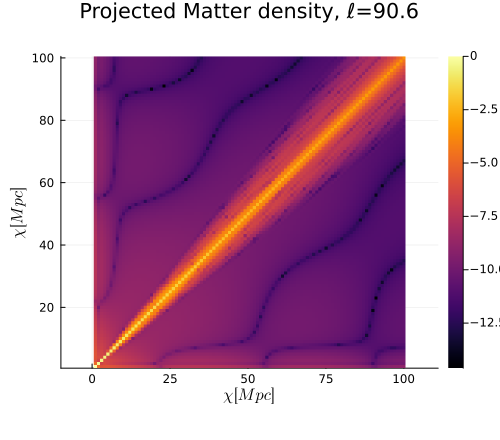

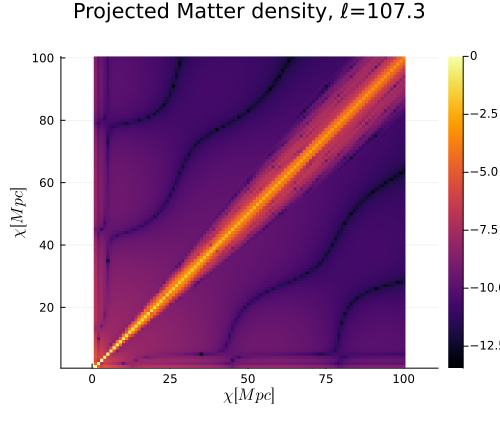

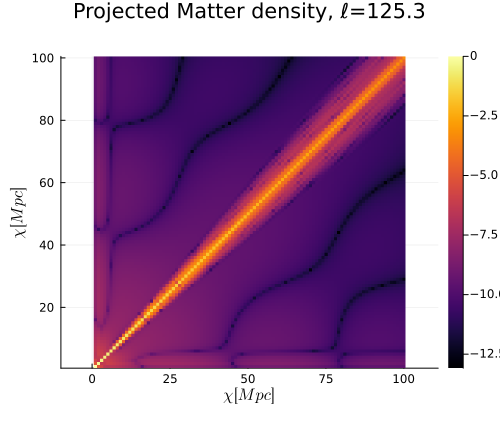

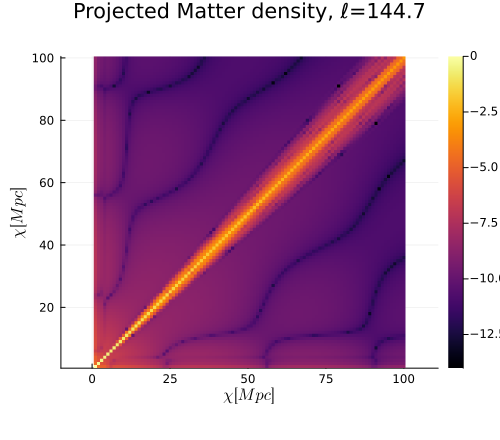

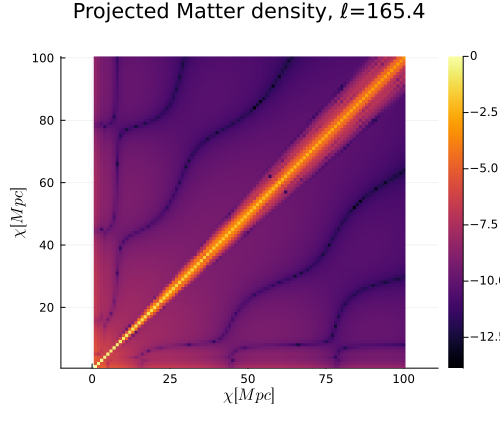

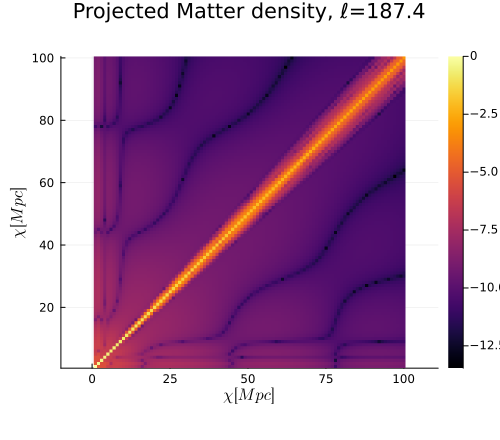

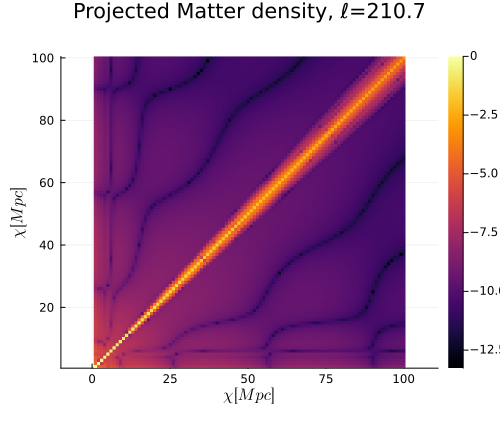

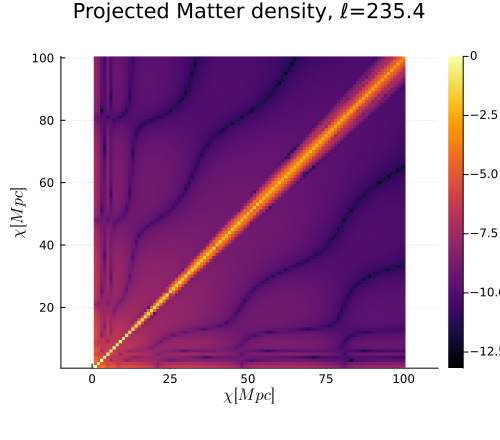

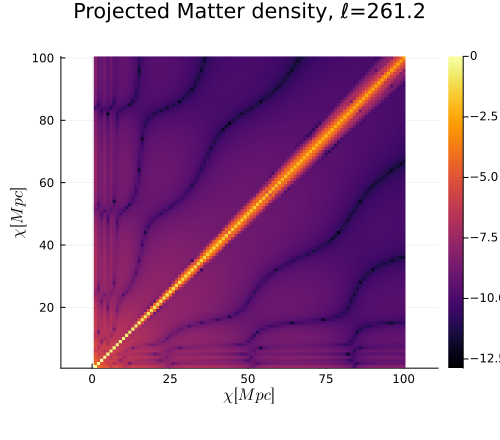

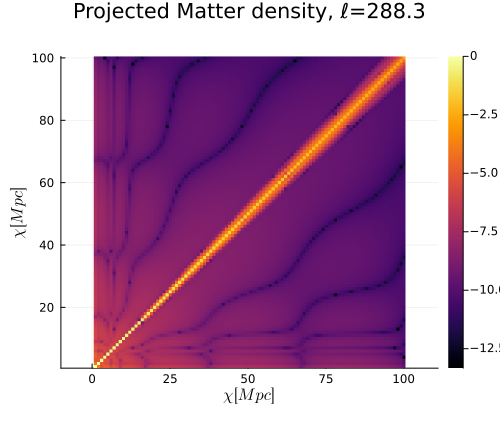

In [75]:
plots = []
for i in 1:21
    push!(plots, plot_pmd(w_CC, i))
end

for plot in plots
    display(plot)
end

##### LENSING - LENSING

In [76]:
function load_T_LL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(length(ell_vector), nχ, nχ, n_cheb+1)
    for i in 1:5
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_LL/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [77]:
T_LL = load_T_LL(nχ, n_cheb)
w_LL = Will.w_ell_tullio(coeff, T_LL);

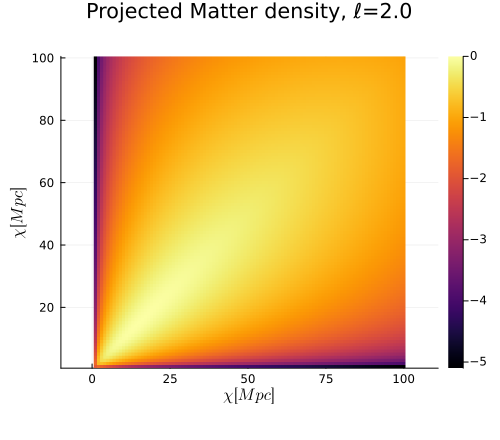

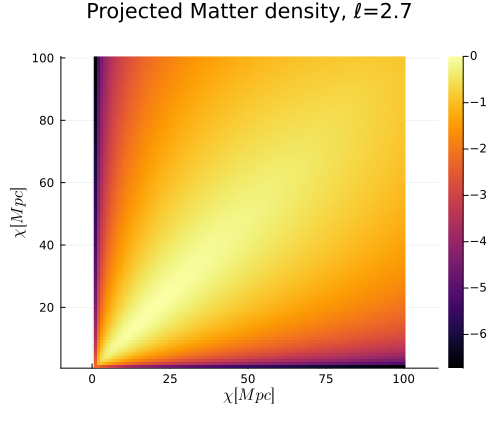

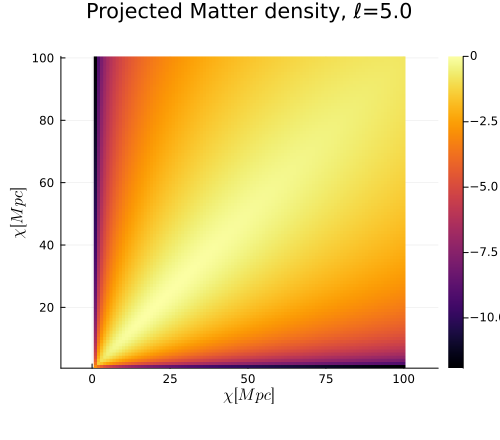

In [78]:
plots = []
for i in 1:3
    push!(plots, plot_pmd(w_LL, i))
end

for plot in plots
    display(plot)
end

    For now it looks pretty good, but remember that the problems started to arise for higher $\ell$'s so we actually have to wait for narval.

##### CLUSTERING - LENSING

In [79]:
function load_T_CL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(length(ell_vector), nχ, nχ, n_cheb+1)
    for i in 1:4
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_CL/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [80]:
T_CL = load_T_CL(nχ, n_cheb)
w_CL = Will.w_ell_tullio(coeff, T_CL);

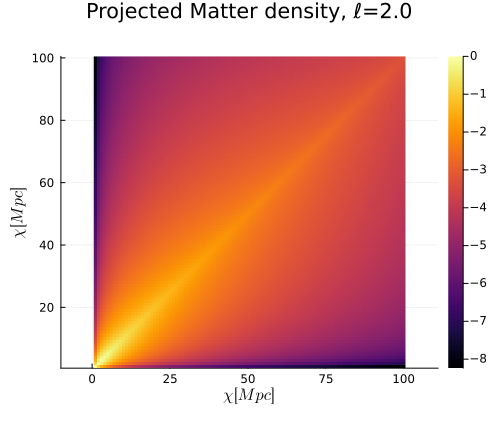

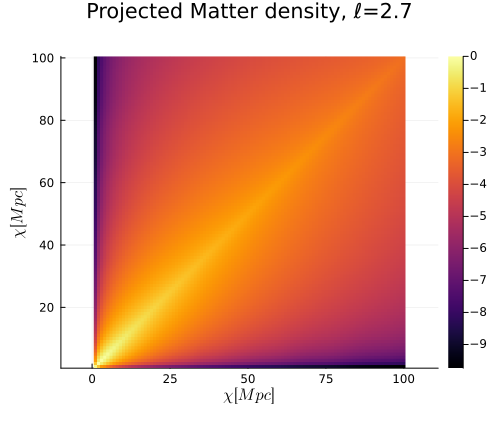

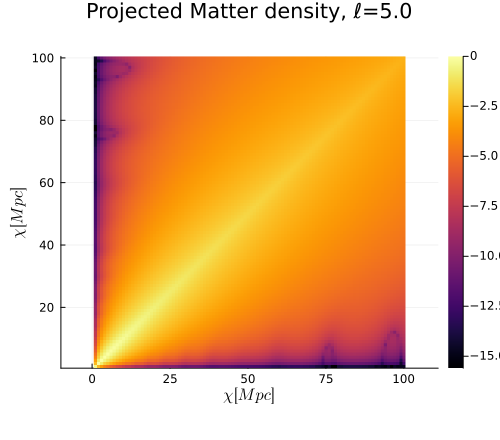

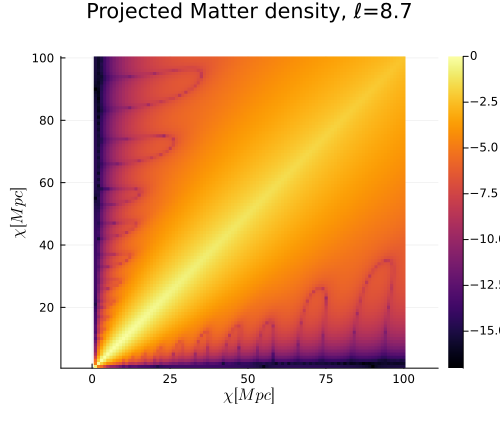

In [81]:
plots = []
for i in 1:4
    push!(plots, plot_pmd(w_CL, i))
end

for plot in plots
    display(plot)
end

##### A closer look into the diagonals

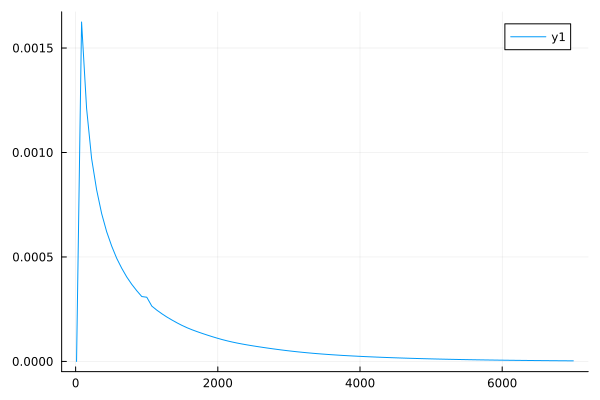

In [293]:
i = 19
plot(χ, diag(w_CC[i,:,:]))

    All diagonals for clustering-clustering are smooth, except for the small bumb in i=19

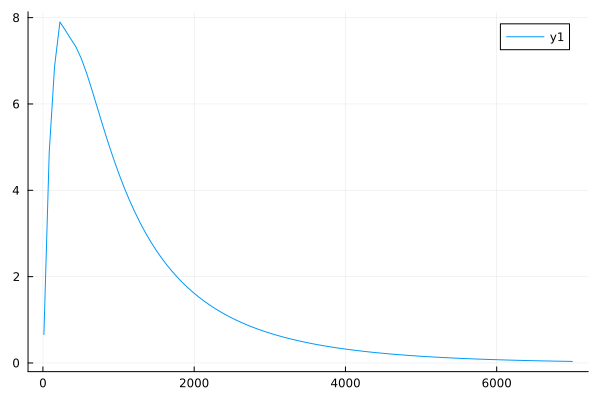

In [294]:
i = 4
plot(χ, diag(w_CL[i,:,:]))

    The first 4 l's have smooth diagonals

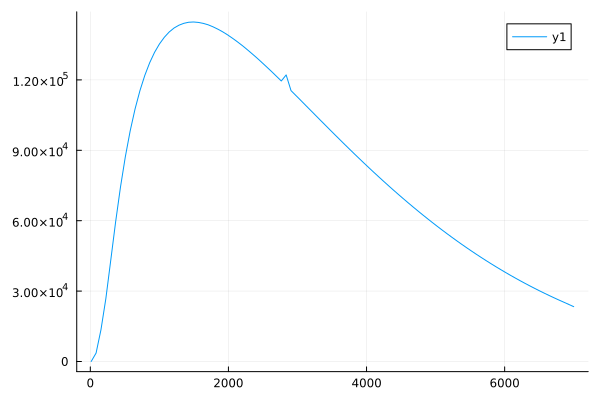

In [147]:
i = 3
plot(χ, diag(w_LL[i,:,:]))

    The first 5 are smooth, except from this small bump in 3

# $w_{\ell}$ brute force integrals

In [82]:
function load_ws_CC(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "w_brute_CC/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end

function load_ws_LL(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "w_brute_LL/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end

function load_ws_CL(nχ, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_w = zeros(length(ell_vector), nχ, nχ)
    for i in 1:length(ell_vector)
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "w_brute_CL/w_brute_l_$l_string.npy"
        full_w[i,:,:] = npzread(filename)
    end
    return full_w
end;

In [83]:
w_brute_CC = load_ws_CC(nχ)
w_brute_LL = load_ws_LL(nχ)
w_brute_CL = load_ws_CL(nχ);

### Comparing diagonals

#### Clustering - clustering

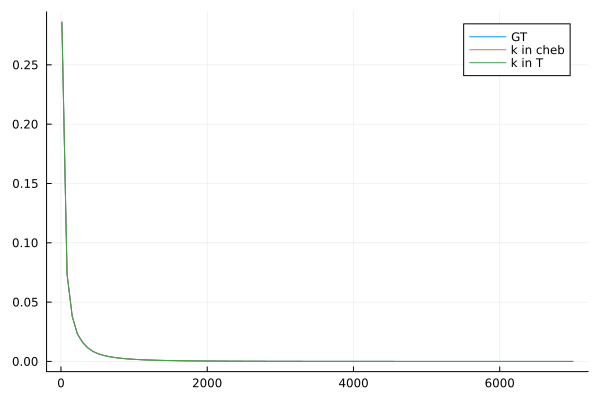

In [183]:
i = 5
plot(χ, diag(w_brute_CC[i,:,:]), label = "GT")
plot!(χ, diag(ws_cheb_CC[i,:,:]), label="k in cheb" )
plot!(χ, diag(w_CC[i,:,:]), label = "k in T")

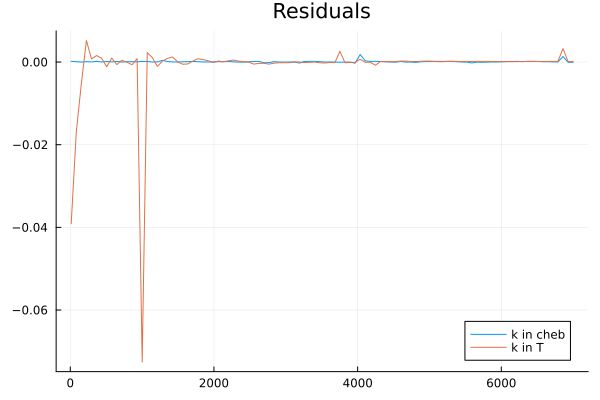

In [185]:
i = 19
plot(χ, 1 .- (diag(ws_cheb_CC[1,:,:]) ./ diag(w_brute_CC[1,:,:])), label = "k in cheb", title = "Residuals")
plot!(χ, 1 .- ( diag(w_CC[i,:,:]) ./ diag(w_brute_CC[i,:,:]) ), label = "k in T")

#### Lensing - lensing

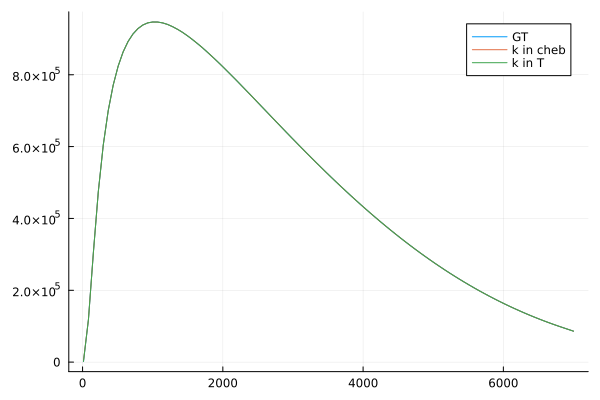

In [166]:
i=1
plot(χ, diag(w_brute_LL[i,:,:]), label = "GT")
plot!(χ, diag(ws_cheb_LL[i,:,:]), label="k in cheb" )
plot!(χ, diag(w_LL[i,:,:]), label = "k in T")

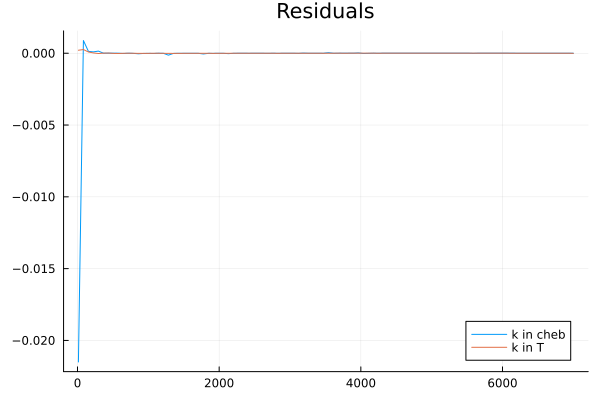

In [186]:
i=2
plot(χ, 1 .- (diag(ws_cheb_LL[i,:,:]) ./ diag(w_brute_LL[i,:,:])), label = "k in cheb", title = "Residuals")
plot!(χ, 1 .- ( diag(w_LL[i,:,:]) ./ diag(w_brute_LL[i,:,:]) ), label = "k in T")

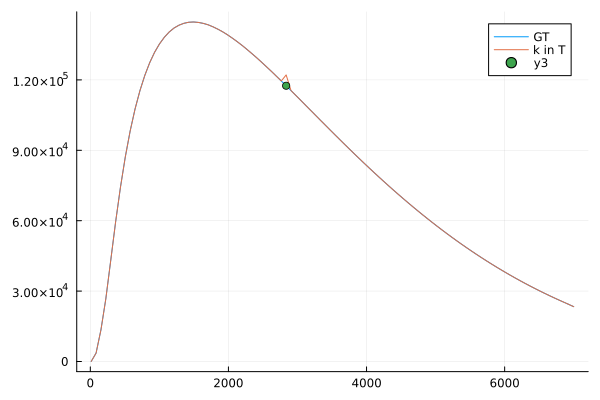

In [75]:
plot(χ, diag(w_brute_LL[3,:,:]), label = "GT")
#plot!(χ, diag(ws_cheb_LL[2,:,:]), label="k in cheb" )
plot!(χ, diag(w_LL[3,:,:]), label = "k in T")
scatter!([χ[41]], [w_fix_41[1,41,41]])

    The green point was calculated with the k factor in T in my local computer. This suggests that the problem is some noise in the Narval nodes.

#### Clustering - lensing

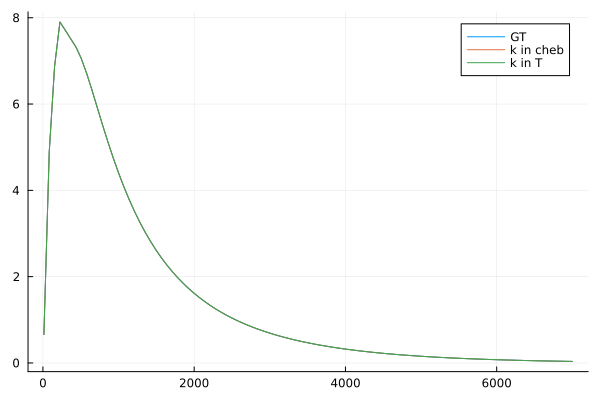

In [177]:
i = 4
plot(χ, diag(w_brute_CL[i,:,:]), label = "GT")
plot!(χ, diag(ws_cheb_CL[i,:,:]), label="k in cheb" )
plot!(χ, diag(w_CL[i,:,:]), label = "k in T")

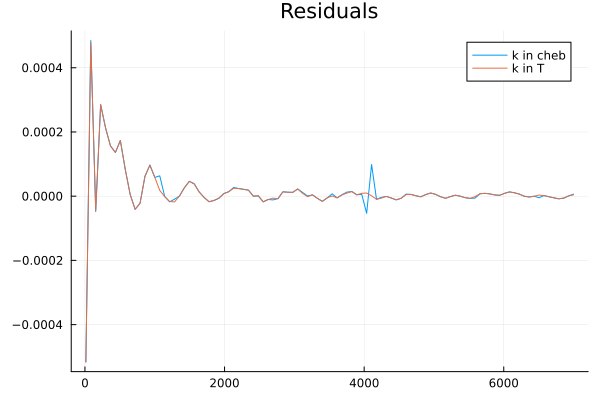

In [181]:
i=4
plot(χ, 1 .- (diag(ws_cheb_CL[i,:,:]) ./ diag(w_brute_CL[i,:,:])), label = "k in cheb", title = "Residuals")
plot!(χ, 1 .- ( diag(w_CL[i,:,:]) ./ diag(w_brute_CL[i,:,:]) ), label = "k in T")

### Comparing them all 

#### Clustering-clustering

In [84]:
i = 19
heatmap(log10.(abs.(1 .- ws_cheb_CC[2,:,:] ./ w_brute_CC[2,:,:])), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Residuals")

LoadError: UndefVarError: `ws_cheb_CC` not defined

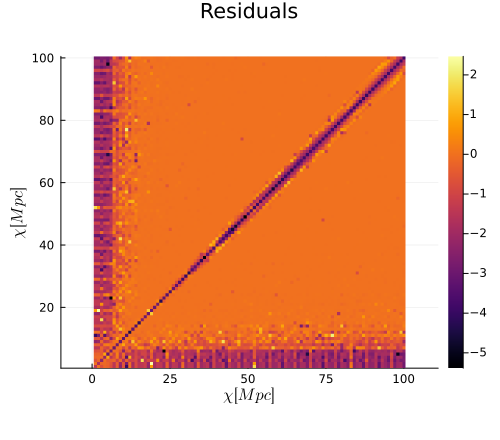

In [23]:
i = 19
heatmap(log10.(abs.(1 .- w_CC[i,:,:] ./ w_brute_CC[i,:,:])), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Residuals")

In [24]:
heatmap(w_CC[19,:,:] .- ws_cheb_CC[19,:,:], aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Differences")

LoadError: UndefVarError: `ws_cheb_CC` not defined

#### Lensing - lensing

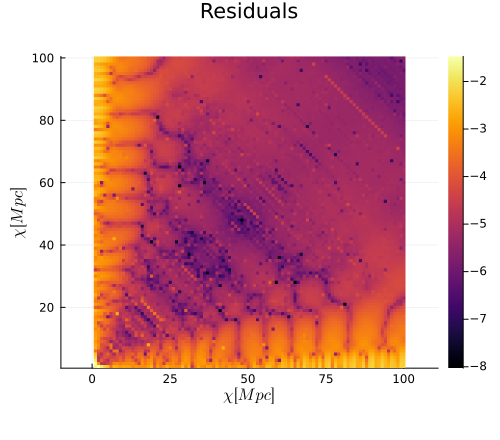

In [190]:
heatmap(log10.(abs.(1 .- ws_cheb_LL[2,:,:] ./ w_brute_LL[2,:,:])), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Residuals")

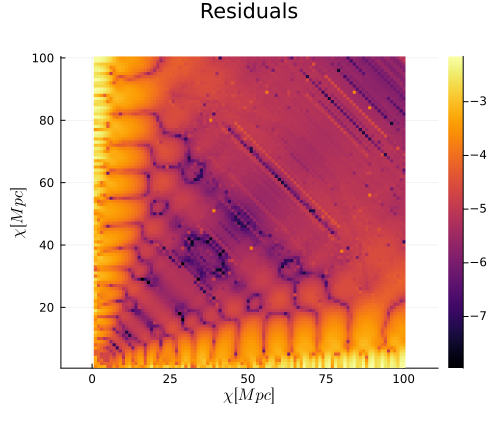

In [191]:
heatmap(log10.(abs.(1 .- w_LL[2,:,:] ./ w_brute_LL[2,:,:])), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Residuals")

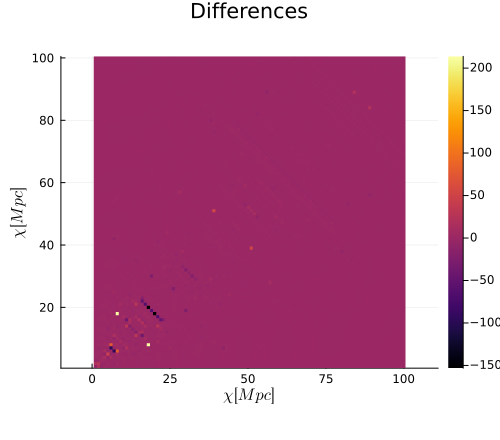

In [192]:
heatmap(w_LL[2,:,:] .- ws_cheb_LL[2,:,:], aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Differences")

#### Clustering - lensing

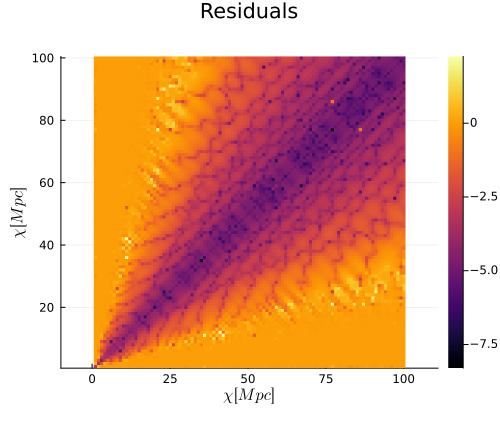

In [193]:
heatmap(log10.(abs.(1 .- ws_cheb_CL[4,:,:] ./ w_brute_CL[4,:,:])), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Residuals")

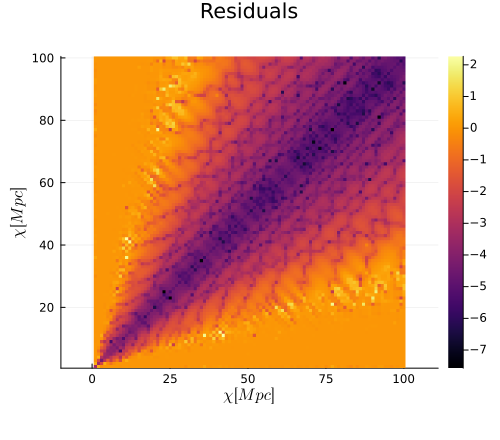

In [194]:
heatmap(log10.(abs.(1 .- w_CL[4,:,:] ./ w_brute_CL[4,:,:])), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Residuals")

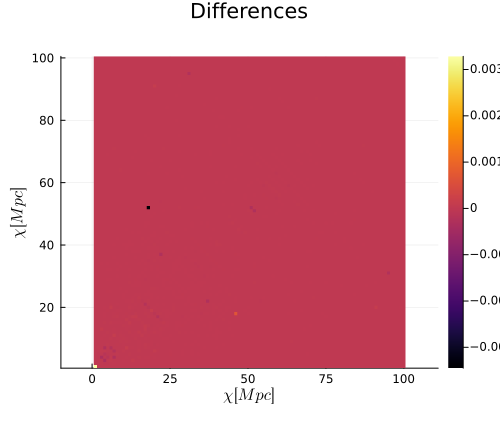

In [195]:
heatmap(w_CL[1,:,:] .- ws_cheb_CL[1,:,:], aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Differences")

## Tests of higher integration accuracy
**DON'T RECOMPILE PLS**

    Here I'm calculating T_tilde_CC (so with k factors) with higher integration accuracy and only along the diagonal (just a test). I did that for the two extreme cases: l = 2 and l = 288.

In [55]:
function double_bessel_integral!(result, f, kmin, kmax, i, j, ℓ, χ)
    benchmark_f(x) = Bessels.sphericalbesselj.(ℓ, χ[i] * x) * Bessels.sphericalbesselj.(ℓ, χ[j] * x)*f(log10(x))*x^2
    int, err = HCubature.hquadrature(benchmark_f, kmin, kmax; rtol=sqrt(1e-13), atol=0, maxevals=Int(1e8), initdiv=1)
    #println("Result ", int)
    result[i,j] = int
    result[j,i] = int
    return nothing
end

function cheb_integral(result, n_cheb, i, j, ℓ, χ, kmin, kmax, c)
    w = zeros(n_cheb+1)
    Threads.@threads for myi in 1:n_cheb+1
        copy_c = deepcopy(c) #copio l'interpolante 
        copy_c.coefs .*= 0 #azzero i coeff del polinomio
        copy_c.coefs[myi] = 1. #tranne quello in posizione i (quello che voglio interpolare)
        double_bessel_integral!(result, copy_c, kmin, kmax, i, j, ℓ, χ)  #TODO check log scale, it's very inconsistent!
        w[myi] = result[i,j]
    end
    return w
end;

In [56]:
result_scatter = zeros(nχ, nχ)
T = zeros(1,nχ,nχ,n_cheb+1)
for i in 1:100
    println("i= $i")
    T[1, i, i, :] = cheb_integral(result_scatter, n_cheb, i, i, ell_vector[21], χ, kmin, kmax, c)
end
w_test = Will.w_ell_tullio(coeff, T);

i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29
i= 30
i= 31
i= 32
i= 33
i= 34
i= 35
i= 36
i= 37
i= 38
i= 39
i= 40
i= 41
i= 42
i= 43
i= 44
i= 45
i= 46
i= 47
i= 48
i= 49
i= 50
i= 51
i= 52
i= 53
i= 54
i= 55
i= 56
i= 57
i= 58
i= 59
i= 60
i= 61
i= 62
i= 63
i= 64
i= 65
i= 66
i= 67
i= 68
i= 69
i= 70
i= 71
i= 72
i= 73
i= 74
i= 75
i= 76
i= 77
i= 78
i= 79
i= 80
i= 81
i= 82
i= 83
i= 84
i= 85
i= 86
i= 87
i= 88
i= 89
i= 90
i= 91
i= 92
i= 93
i= 94
i= 95
i= 96
i= 97
i= 98
i= 99
i= 100


In [59]:
result_scatter = zeros(nχ, nχ)
T_2 = zeros(1,nχ,nχ,n_cheb+1)
for i in 1:100
    println("i= $i")
    T_2[1, i, i, :] = cheb_integral(result_scatter, n_cheb, i, i, ell_vector[1], χ, kmin, kmax, c)
end
w_test_2 = Will.w_ell_tullio(coeff, T_2);

i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29
i= 30
i= 31
i= 32
i= 33
i= 34
i= 35
i= 36
i= 37
i= 38
i= 39
i= 40
i= 41
i= 42
i= 43
i= 44
i= 45
i= 46
i= 47
i= 48
i= 49
i= 50
i= 51
i= 52
i= 53
i= 54
i= 55
i= 56
i= 57
i= 58
i= 59
i= 60
i= 61
i= 62
i= 63
i= 64
i= 65
i= 66
i= 67
i= 68
i= 69
i= 70
i= 71
i= 72
i= 73
i= 74
i= 75
i= 76
i= 77
i= 78
i= 79
i= 80
i= 81
i= 82
i= 83
i= 84
i= 85
i= 86
i= 87
i= 88
i= 89
i= 90
i= 91
i= 92
i= 93
i= 94
i= 95
i= 96
i= 97
i= 98
i= 99
i= 100


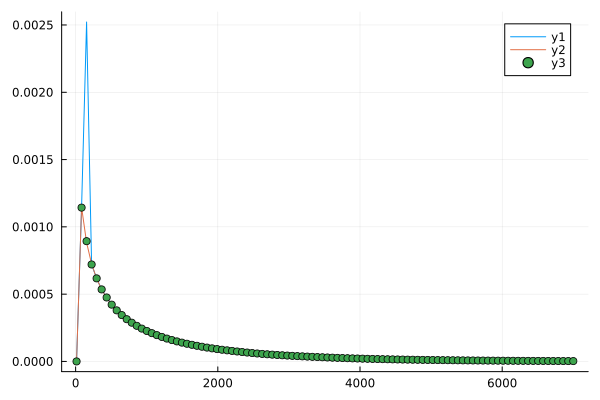

In [57]:
plot(χ, diag(w_CC[21,:,:]) )
plot!(χ, diag(ws_cheb_CC[21,:,:]) )
scatter!(χ, diag(w_test[1,:,:]))

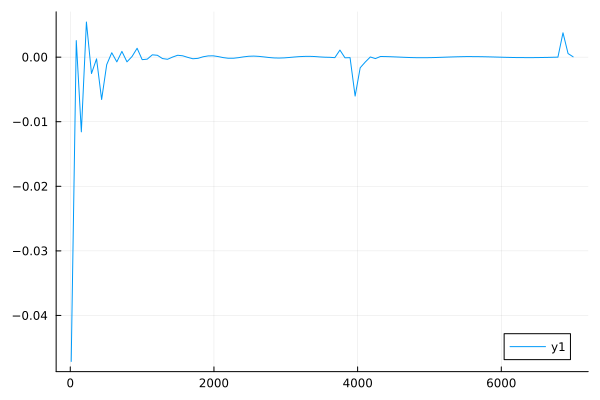

In [58]:
plot(χ, 1 .- (diag(w_test[1,:,:]) ./ diag(ws_cheb_CC[21,:,:])))

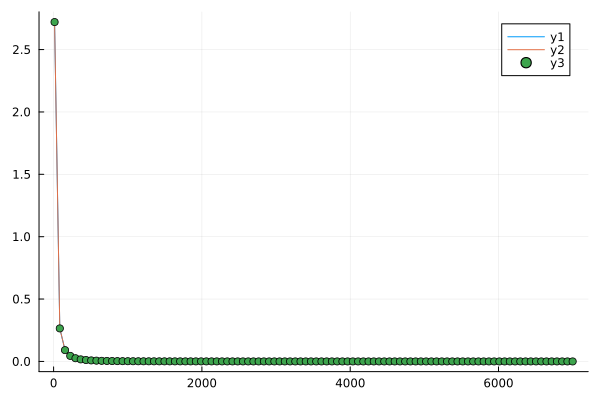

In [60]:
plot(χ, diag(w_CC[1,:,:]) )
plot!(χ, diag(ws_cheb_CC[1,:,:]) )
scatter!(χ, diag(w_test_2[1,:,:]))

    This is to show that an higher accuracy actually solves the problem. Still need to wait for Narval to finish to actually assess this and polish the results

# Now, to the $C_{\ell}$'s computation!

In [86]:
# REWRITE THIS WITH WEIGHT VECTOR (IT'S MORE ELEGANT)
# THOSE EXTRA FACTORS ARE FOR THE TRAPEZIOD INTEGRATION RULE 
function C_ell_computation_tullio(w, WA, WB)
    @tullio int1[i,m,j] := ((χ[100]-χ[1])/99)*( w[i,l,m]*WA[j,l] -0.5*(w[i,1,m]*WA[j,1] + w[i,100,m]*WA[j,100]))
    @tullio Cℓ[i,j,k] := ((χ[100]-χ[1])/99)*(int1[i,m,j]*WB[k,m] -0.5*(int1[i,1,j]*WB[k,1] + int1[i,100,j]*WB[k,100]))
end;

In [87]:
# ADDING CHI FACTORS TO LENSING WINDOW FUNCTIONS
WA_LL = zeros(5,nχ)
for i in 1:size(WA_interp)[1]
    WA_LL[i,:] = WA_interp[i,:] ./ (Array(χ) .^ 2)
end;

### $k$ factors in Chebyshev decomposition

In [199]:
Cℓ_CC = C_ell_computation_tullio(ws_cheb_CC, WB_interp, WB_interp);
Cℓ_LL = C_ell_computation_tullio(ws_cheb_LL, WA_LL, WA_LL)
Cℓ_CL = C_ell_computation_tullio(ws_cheb_CL, WA_LL, WB_interp);

In [200]:
# ADDING ELL PREFACTORS
Cℓ_CC = Cℓ_CC .* (2/π)

function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end

ell_vector = npzread("ell_vector.npy")
for i in 1:length(ell_vector)
    Cℓ_LL[i,:,:] = Cℓ_LL[i,:,:] .* 2 .* factorial_frac(ell_vector[i]) ./ π
    Cℓ_CL[i,:,:] = Cℓ_CL[i,:,:] .* 2 .* sqrt.(factorial_frac(ell_vector[i])) ./ π
end

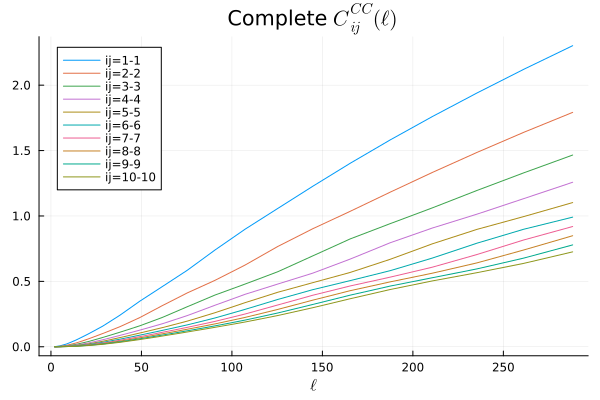

In [201]:
ℓ = npzread("ell_vector.npy")
p = plot(title=L"Complete $C_{ij}^{CC}(\ell)$", xlabel=L"\ell")
for i in 1:10
    plot!(p,ℓ, Cℓ_CC[:,i,i] .* ℓ .* (ℓ .+ 1), label = "ij=" * string(i)*"-"*string(i))
end
p

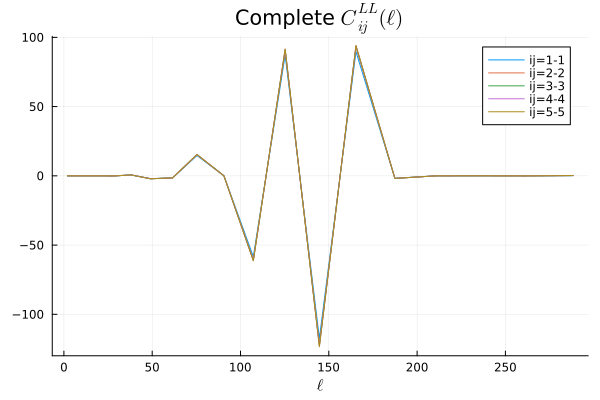

In [202]:
p = plot(title=L"Complete $C_{ij}^{LL}(\ell)$", xlabel=L"\ell")
for i in 1:5
    plot!(p,ℓ, Cℓ_LL[:,i,i] .* ℓ .* (ℓ .+ 1), label = "ij=" * string(i)*"-"*string(i))
end
p

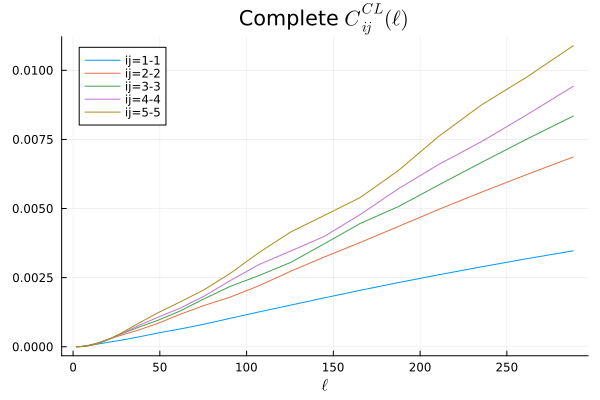

In [203]:
p = plot(title=L"Complete $C_{ij}^{CL}(\ell)$", xlabel=L"\ell")
for i in 1:5
    plot!(p,ℓ, Cℓ_CL[:,i,i] .* ℓ .* (ℓ .+ 1), label = "ij=" * string(i)*"-"*string(i))
end
p

In [31]:
#N5K Cℓ's 
benchmark_gg = npzread("../N5K/tests/benchmarks_nl_full_clgg.npz")
benchmark_ll = npzread("../N5K/tests/benchmarks_nl_full_clss.npz")
benchmark_gl = npzread("../N5K/tests/benchmarks_nl_full_clgs.npz");

In [32]:
gg = benchmark_gg["cls"]
ll = benchmark_ll["cls"]
gl = benchmark_gl["cls"]
ell = benchmark_gg["ls"];

In [33]:
gg_reshaped = zeros(length(ell), 10, 10)
counter = 1

for i in 1:10
    for j in i:10
        gg_reshaped[:,i,j] = gg[counter, :]
        gg_reshaped[:,j,i] = gg_reshaped[:,i,j]
        counter += 1
    end
end

In [34]:
ll_reshaped = zeros(length(ell), 5, 5)
counter = 1

for i in 1:5
    for j in i:5
        ll_reshaped[:,i,j] = ll[counter, :]
        ll_reshaped[:,j,i] = ll_reshaped[:,i,j]
        counter += 1
    end
end

In [35]:
gl_reshaped = zeros(length(ell), 10, 5)
counter = 1

for i in 1:10
    for j in i:5
        gl_reshaped[:,i,j] = gl[counter, :]
        gl_reshaped[:,j,i] = gl_reshaped[:,i,j]
        counter += 1
    end
end

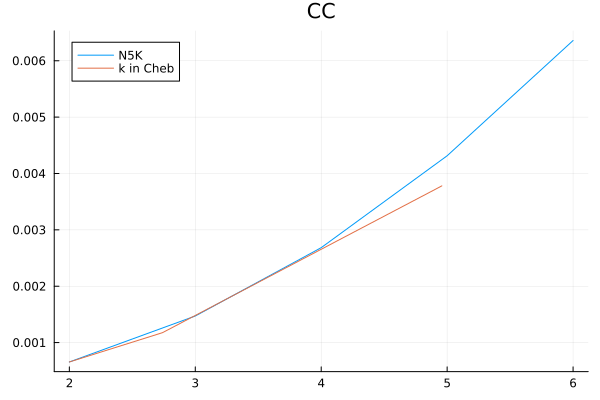

In [36]:
plot(ell[1:5], gg[1,1:5] .* ell[1:5] .* (ell[1:5] .+ 1), title = "CC", label="N5K")
plot!(ℓ[1:3], gg[1,1] *Cℓ_CC[1:3,1,1] /Cℓ_CC[1,1,1] .* ℓ[1:3] .* (ℓ[1:3] .+ 1) , label = "k in Cheb")

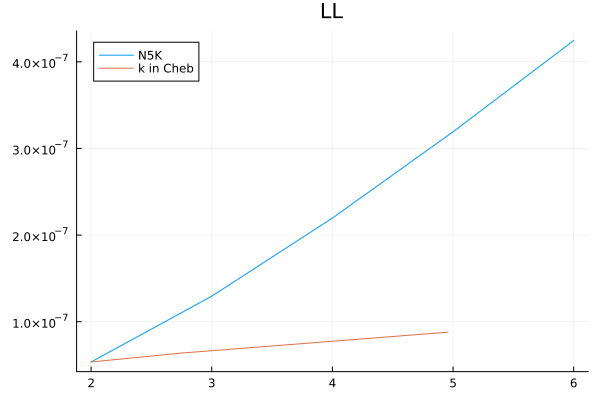

In [37]:
plot(ell[1:5], ll[1,1:5] .* ell[1:5] .* (ell[1:5] .+ 1), title = "LL", label="N5K")
plot!(ℓ[1:3], ll[1,1] *Cℓ_LL[1:3,1,1] /Cℓ_LL[1,1,1] .* ℓ[1:3] .* (ℓ[1:3] .+ 1) , label = "k in Cheb")

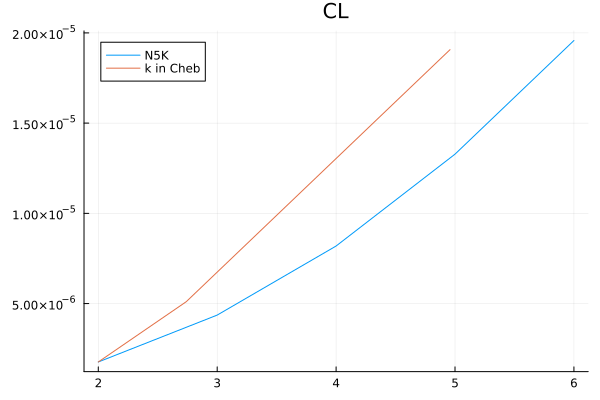

In [38]:
plot(ell[1:5], gl[1,1:5] .* ell[1:5] .* (ell[1:5] .+ 1), title = "CL", label="N5K")
plot!(ℓ[1:3], gl[1,1] *Cℓ_CL[1:3,1,1] /Cℓ_CL[1,1,1] .* ℓ[1:3] .* (ℓ[1:3] .+ 1) , label = "k in Cheb")

### $C_{\ell}$'s with k in $\tilde T$

In [88]:
Cℓ_CC = C_ell_computation_tullio(w_CC, WB_interp, WB_interp);
Cℓ_LL = C_ell_computation_tullio(w_LL, WA_LL, WA_LL)
Cℓ_CL = C_ell_computation_tullio(w_CL, WA_LL, WB_interp);

In [89]:
Cℓ_CC_b = C_ell_computation_tullio(w_brute_CC, WB_interp, WB_interp);
Cℓ_LL_b = C_ell_computation_tullio(w_brute_LL, WA_LL, WA_LL)
Cℓ_CL_b = C_ell_computation_tullio(w_brute_CL, WA_LL, WB_interp);

In [90]:
# ADDING ELL PREFACTORS
Cℓ_CC = Cℓ_CC .* (2/π)

function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end

ell_vector = npzread("ell_vector.npy")
for i in 1:length(ell_vector)
    Cℓ_LL[i,:,:] = Cℓ_LL[i,:,:] .* 2 .* factorial_frac(ell_vector[i]) ./ π
    Cℓ_CL[i,:,:] = Cℓ_CL[i,:,:] .* 2 .* sqrt.(factorial_frac(ell_vector[i])) ./ π
end

In [91]:
# ADDING ELL PREFACTORS
Cℓ_CC_b = Cℓ_CC_b .* (2/π)

function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end

ell_vector = npzread("ell_vector.npy")
for i in 1:length(ell_vector)
    Cℓ_LL[i,:,:] = Cℓ_LL[i,:,:] .* 2 .* factorial_frac(ell_vector[i]) ./ π
    Cℓ_CL[i,:,:] = Cℓ_CL[i,:,:] .* 2 .* sqrt.(factorial_frac(ell_vector[i])) ./ π
end

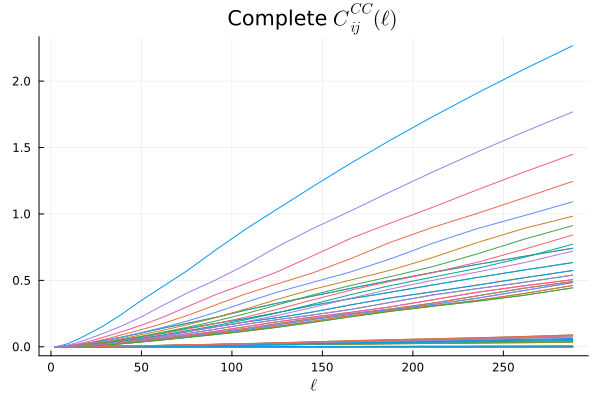

In [92]:
p = plot(title=L"Complete $C_{ij}^{CC}(\ell)$", xlabel=L"\ell")
ℓ = npzread("ell_vector.npy")
for i in 1:10
    for j in 1:10
        plot!(p,ℓ, Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1), label=nothing) #label = "ij=" * string(i)*"-"*string(j))
    end
end
p

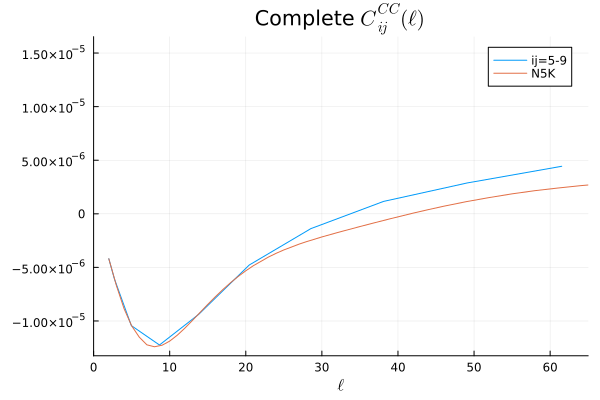

In [93]:
p = plot(title=L"Complete $C_{ij}^{CC}(\ell)$", xlabel=L"\ell", xlim=(0,65))
ℓ = npzread("ell_vector.npy")
for i in 5:5
    for j in 9:9
        plot!(p,ℓ[1:10], gg_reshaped[1,i,j]*Cℓ_CC[1:10,i,j]/Cℓ_CC[1,i,j] .* ℓ[1:10] .* (ℓ[1:10] .+ 1), label="ij=" * string(i)*"-"*string(j)) #label = "ij=" * string(i)*"-"*string(j))
        plot!(p, ell[1:90], gg_reshaped[1:90,i,j] .* ell[1:90] .* (ell[1:90] .+ 1), label = "N5K")

    end
end
p

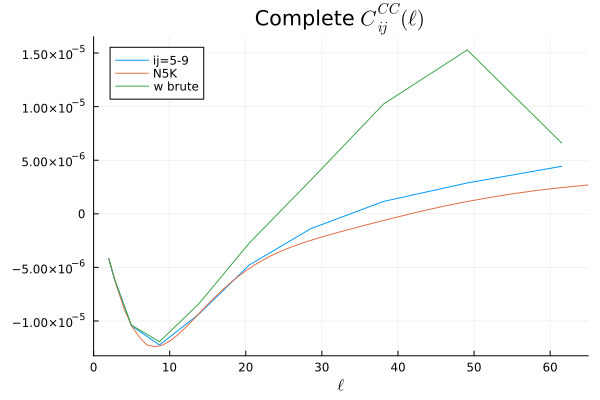

In [94]:
p = plot(title=L"Complete $C_{ij}^{CC}(\ell)$", xlabel=L"\ell", xlim=(0,65))
ℓ = npzread("ell_vector.npy")
for i in 5:5
    for j in 9:9
        plot!(p,ℓ[1:10], gg_reshaped[1,i,j]*Cℓ_CC[1:10,i,j]/Cℓ_CC[1,i,j] .* ℓ[1:10] .* (ℓ[1:10] .+ 1), label="ij=" * string(i)*"-"*string(j)) #label = "ij=" * string(i)*"-"*string(j))
        plot!(p, ell[1:90], gg_reshaped[1:90,i,j] .* ell[1:90] .* (ell[1:90] .+ 1), label = "N5K")
        plot!(p,ℓ[1:10], gg_reshaped[1,i,j]*Cℓ_CC_b[1:10,i,j]/Cℓ_CC_b[1,i,j] .* ℓ[1:10] .* (ℓ[1:10] .+ 1), label="w brute")

    end
end
p

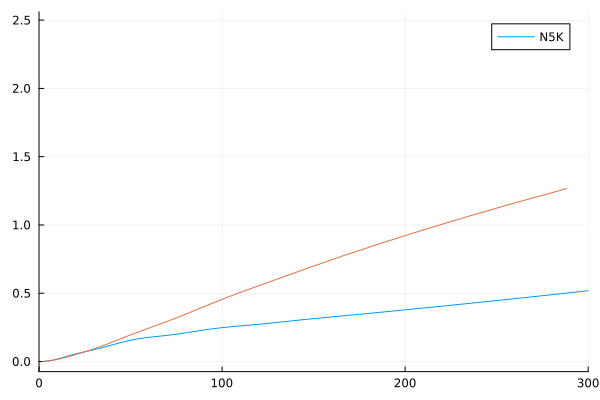

In [95]:
i = 1
plot(ell, gg[i,:] .* ell .* (ell .+ 1), label = "N5K", xlims = (0,300))
plot!(ℓ, gg[1,1]*Cℓ_CC[:,i,i]/Cℓ_CC[1,1,1] .* ℓ .* (ℓ .+ 1), label=nothing) #label = "ij=" * string(i)*"-"*string(j))

### Lensing-lensing

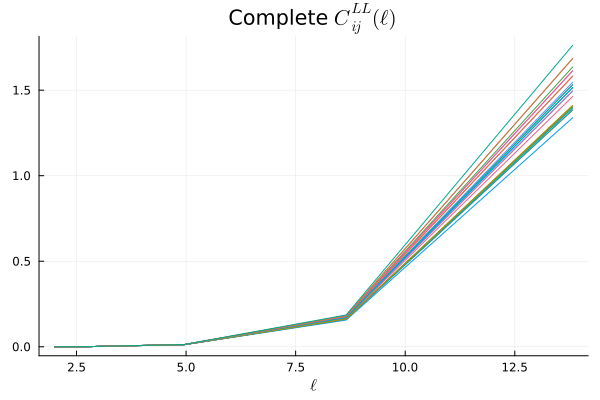

In [96]:
p = plot(title=L"Complete $C_{ij}^{LL}(\ell)$", xlabel=L"\ell")
for i in 1:5
    for j in 1:5
        plot!(p,ℓ[1:5], Cℓ_LL[1:5,i,j] .* ℓ[1:5] .* (ℓ[1:5] .+ 1), label=nothing) #label = "ij=" * string(i)*"-"*string(j))
    end
end
p

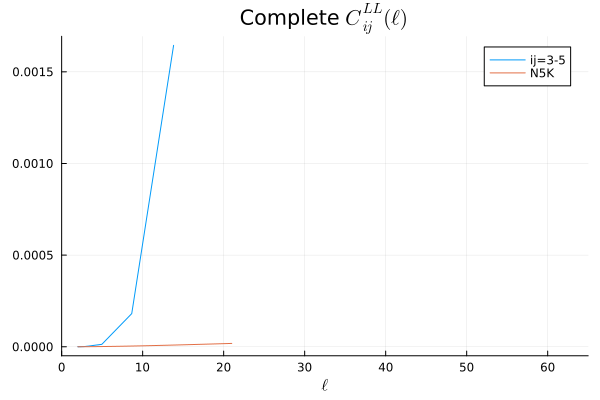

In [97]:
p = plot(title=L"Complete $C_{ij}^{LL}(\ell)$", xlabel=L"\ell", xlim=(0,65))
for i in 3:3
    for j in 5:5
        plot!(p,ℓ[1:5], ll_reshaped[1,i,j]*Cℓ_LL[1:5,i,j]/Cℓ_LL[1,i,j] .* ℓ[1:5] .* (ℓ[1:5] .+ 1), label="ij=" * string(i)*"-"*string(j)) #label = "ij=" * string(i)*"-"*string(j))
        plot!(p, ell[1:20], ll_reshaped[1:20,i,j] .* ell[1:20] .* (ell[1:20] .+ 1), label = "N5K")

    end
end
p

### Clustering-lensing

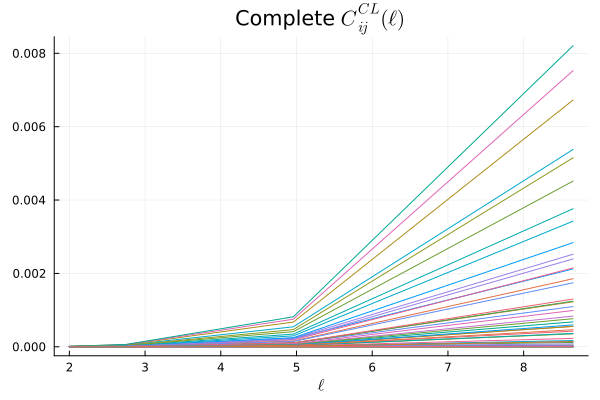

In [98]:
p = plot(title=L"Complete $C_{ij}^{CL}(\ell)$", xlabel=L"\ell")
for i in 1:5
    for j in 1:10
        plot!(p,ℓ[1:4], Cℓ_CL[1:4,i,j] .* ℓ[1:4] .* (ℓ[1:4] .+ 1), label=nothing) #label = "ij=" * string(i)*"-"*string(j))
    end
end
p

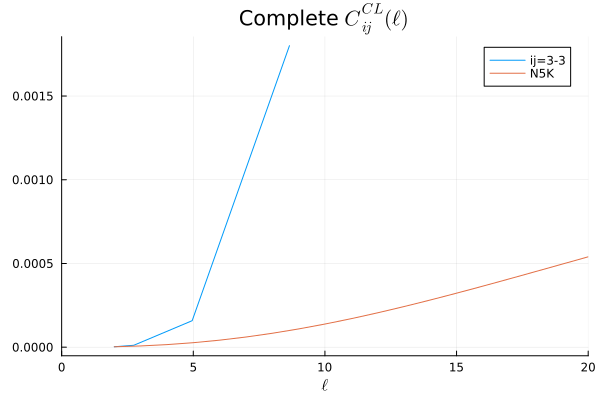

In [99]:
p = plot(title=L"Complete $C_{ij}^{CL}(\ell)$", xlabel=L"\ell", xlim=(0,20))
for i in 3:3
    for j in 3:3
        plot!(p,ℓ[1:4], gl_reshaped[1,i,j]*Cℓ_CL[1:4,i,j]/Cℓ_CL[1,i,j] .* ℓ[1:4] .* (ℓ[1:4] .+ 1), label="ij=" * string(i)*"-"*string(j)) #label = "ij=" * string(i)*"-"*string(j))
        plot!(p, ell[1:20], gl_reshaped[1:20,i,j] .* ell[1:20] .* (ell[1:20] .+ 1), label = "N5K")

    end
end
p